In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Read Dataset

In [2]:
df = pd.read_csv('day.csv')

In [3]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


## Visualize data

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

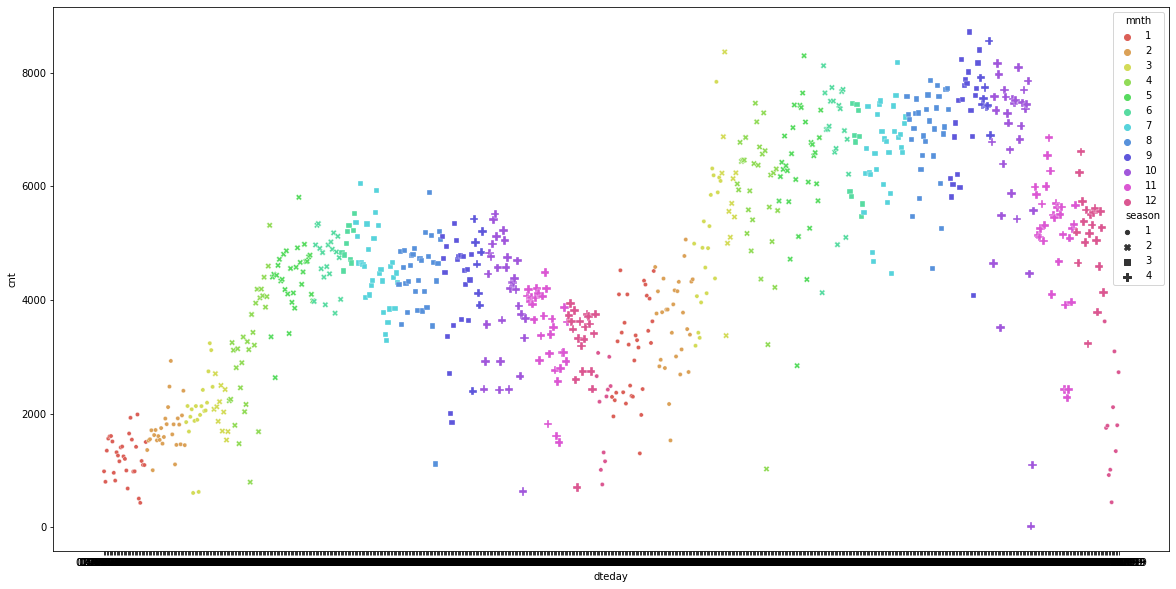

In [6]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = df, x = 'dteday',y='cnt',hue = 'mnth',style = 'season',size = 'season',palette=sns.color_palette("hls", 12))

Since most of the date related data is already present in other columns such as mnth and yr, we can delete instant and dteday columns

Also, 'casual' and 'registered' are the columns we neither want to predict nor want to use to predict 'cnt'

So let's drop all those columns

In [7]:
df = df.drop(['instant','dteday','casual','registered'],axis=1)

In [8]:
cat_cols = ['season','mnth','weekday','weathersit']

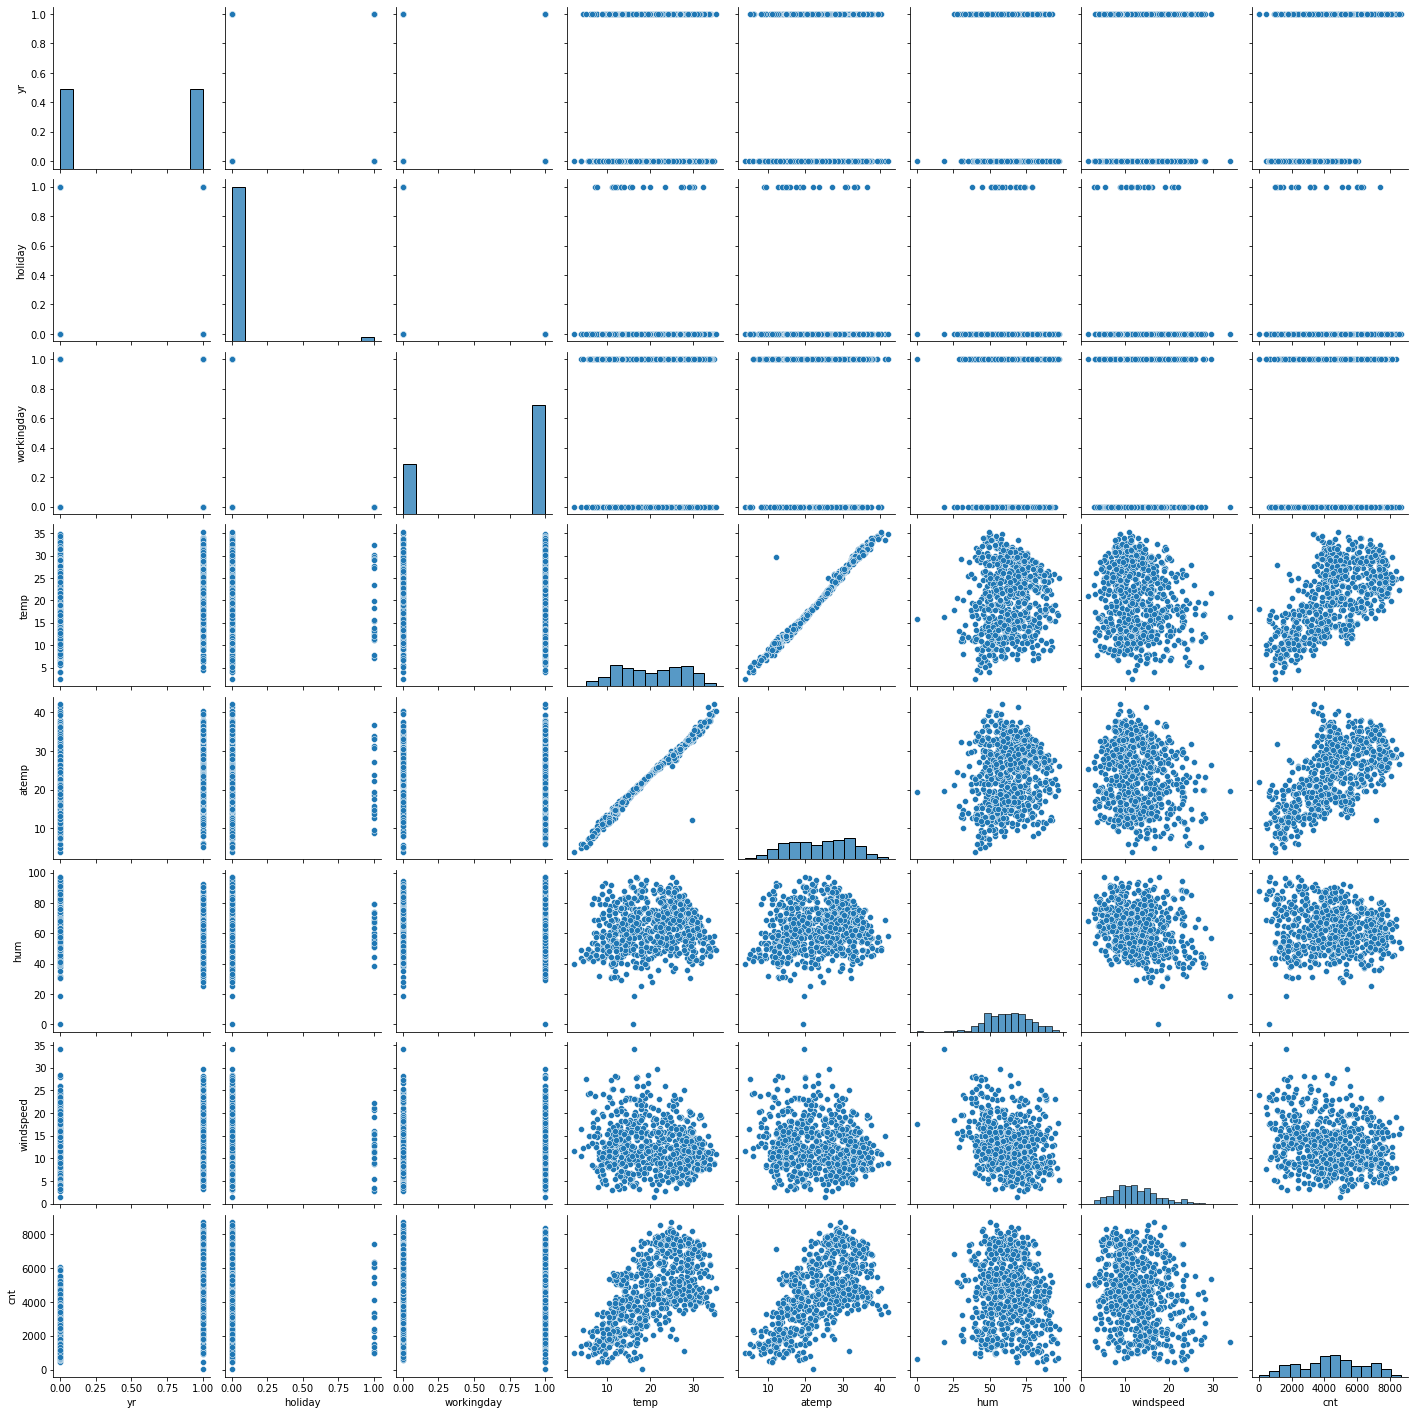

In [9]:
sns.pairplot(df.drop(cat_cols,axis=1))

<AxesSubplot:>

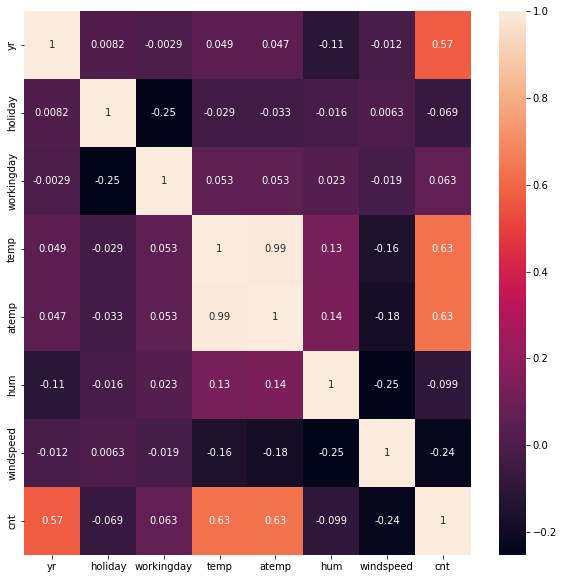

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(df.drop(cat_cols,axis=1).corr(),annot=True)

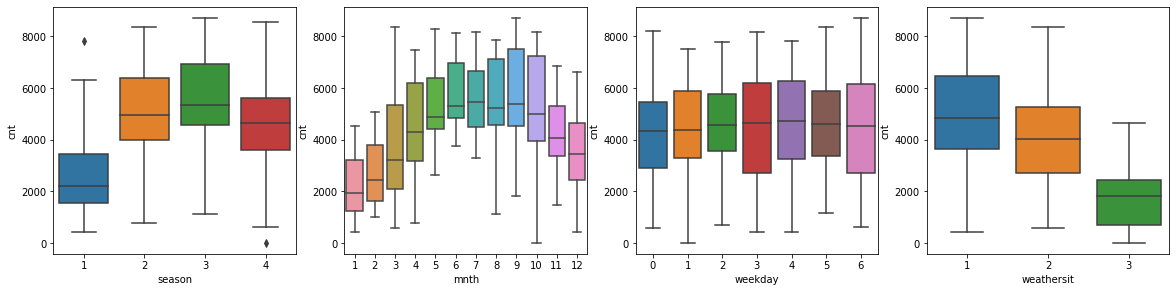

In [11]:
plt.figure(figsize=(20,10))
i = 1
for col in cat_cols:
    plt.subplot(2,4,i)
    sns.boxplot(data=df, y = 'cnt',x = col)
    i+=1
plt.show()    

## Feature Engineering

### Categoric to numeric
Turn categorical data into numeric vectors

In [12]:
for col in cat_cols:
    df[col] = df[col].apply(lambda x: col+'_'+str(x))
    status = pd.get_dummies(df[col],drop_first=True)
    df = pd.concat([df,status],axis=1)
    df=df.drop(col,axis=1)

In [13]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,1,0,0,0,0,0


### Data splitting to test and training 

In [14]:
df_train,df_test = train_test_split(df,train_size=0.7,random_state=100)

### Rescaling features

In [15]:
scaler = MinMaxScaler()

num_cols = ['temp','atemp','hum','cnt']

df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
576,1,0,1,0.815169,0.766351,0.725633,11.083475,0.827658,0,1,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,10.792293,0.465255,0,0,...,0,0,0,0,0,0,0,1,1,0
728,1,0,0,0.245101,0.200348,0.498067,23.500518,0.204096,0,0,...,0,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,8.708325,0.482973,1,0,...,0,0,0,0,0,0,0,1,1,0
111,0,0,1,0.345824,0.318819,0.751824,14.707907,0.191095,1,0,...,0,0,0,0,0,0,1,0,1,0


In [16]:
df_test[num_cols] = scaler.transform(df_test[num_cols])

In [17]:
X_train = df_train.drop(['cnt'],axis=1)
y_train = df_train.cnt

## Feature selection

### RFE

In [18]:
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm, n_features_to_select=10)
rfe = rfe.fit(X_train,y_train)

In [19]:
sorted(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), key=lambda x: x[2])

[('yr', True, 1),
 ('holiday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('season_2', True, 1),
 ('season_4', True, 1),
 ('mnth_8', True, 1),
 ('mnth_9', True, 1),
 ('weathersit_3', True, 1),
 ('weathersit_2', False, 2),
 ('weekday_6', False, 3),
 ('workingday', False, 4),
 ('season_3', False, 5),
 ('mnth_10', False, 6),
 ('mnth_5', False, 7),
 ('mnth_6', False, 8),
 ('mnth_3', False, 9),
 ('mnth_4', False, 10),
 ('mnth_7', False, 11),
 ('mnth_2', False, 12),
 ('weekday_1', False, 13),
 ('weekday_2', False, 14),
 ('weekday_5', False, 15),
 ('mnth_12', False, 16),
 ('mnth_11', False, 17),
 ('windspeed', False, 18),
 ('weekday_3', False, 19),
 ('weekday_4', False, 20)]

In [20]:
col = X_train.columns[rfe.support_]

### Building model using statsmodel, for detailed statistic

In [21]:
X = X_train[col]
X_train_sm = sm.add_constant(X)

#Create first model
lr = sm.OLS(y_train,X_train_sm)

#fit
lr_model = lr.fit()

#summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     218.4
Date:                Sun, 29 Jan 2023   Prob (F-statistic):          4.02e-175
Time:                        15:11:32   Log-Likelihood:                 467.83
No. Observations:                 510   AIC:                            -913.7
Df Residuals:                     499   BIC:                            -867.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1620      0.023      7.157      0.000       0.118       0.207
yr               0.2264      0.009     25.836      0.000       0.209       0.244
holiday         -0.0906      0.028     -3.274      0.001      -0.145      -0.036
temp             0.3555      0.140      2.542      0.011       0.081       0.630
atemp            0.2479      0.147      1.689      0.092      -0.041       0.536
hum             -0.2298      0.032     -7.087      0.000      -0.293      -0.166
season_2         0.0921      0.012      7.851      0.000       0.069       0.115
season_4         0.1542      0.012     13.326      0.000       0.131       0.177
mnth_8           0.0573      0.018      3.228      0.001       0.022       0.092
mnth_9           0.1253      0.017      7.163      0.000       0.091       0.160
weathersit_3    -0.2187      0.027     -8.173      0.000      -0.271      -0.166
==============================================================================
Omnibus:                       62.996   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.061
Skew:                          -0.724   Prob(JB):                     5.15e-27
Kurtosis:                       4.898   Cond. No.                         73.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observation
- p-values of many columns are too high

We shall look into VIF of columns and decide what columns to drop

## Checking VIF
$VIF_i = \frac{1}{1-R^2_i}$

In [22]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif  = vif.sort_values(by = 'VIF',ascending=False)
print(vif)

       Features     VIF
3         atemp  353.79
2          temp  350.65
4           hum    8.54
0            yr    1.98
5      season_2    1.81
6      season_4    1.76
7        mnth_8    1.58
8        mnth_9    1.28
9  weathersit_3    1.10
1       holiday    1.04


### We could have:
- High p-value, high VIF 
- High Low cases
    - High p, low VIF: remove these first
    - Low p, high VIF: remove these after the ones above
- Low p, low VIF

##### Now we remove 'atemp', the column with highest p-value and VIF

In [23]:
X = X.drop('atemp',axis=1)

In [24]:
X_train_sm = sm.add_constant(X)

#Create first model
lr = sm.OLS(y_train,X_train_sm)

#fit
lr_model = lr.fit()

#summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     241.5
Date:                Sun, 29 Jan 2023   Prob (F-statistic):          1.04e-175
Time:                        15:11:32   Log-Likelihood:                 466.38
No. Observations:                 510   AIC:                            -912.8
Df Residuals:                     500   BIC:                            -870.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1600      0.023      7.065      0.000       0.116       0.205
yr               0.2263      0.009     25.776      0.000       0.209       0.244
holiday         -0.0925      0.028     -3.341      0.001      -0.147      -0.038
temp             0.5884      0.023     25.634      0.000       0.543       0.634
hum             -0.2241      0.032     -6.936      0.000      -0.288      -0.161
season_2         0.0936      0.012      7.981      0.000       0.071       0.117
season_4         0.1567      0.011     13.639      0.000       0.134       0.179
mnth_8           0.0532      0.018      3.018      0.003       0.019       0.088
mnth_9           0.1248      0.018      7.122      0.000       0.090       0.159
weathersit_3    -0.2235      0.027     -8.385      0.000      -0.276      -0.171
==============================================================================
Omnibus:                       61.921   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.306
Skew:                          -0.715   Prob(JB):                     2.04e-26
Kurtosis:                       4.877   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif  = vif.sort_values(by = 'VIF',ascending=False)
vif

,Features,VIF
2,temp,8.46
3,hum,8.44
0,yr,1.98
4,season_2,1.81
5,season_4,1.73
6,mnth_8,1.56
7,mnth_9,1.28
8,weathersit_3,1.09
1,holiday,1.03


##### Since all p-values are under threshold, we now remove 'temp', the column with highest VIF

In [26]:
X = X.drop('temp',axis=1)

In [27]:
X_train_sm = sm.add_constant(X)

#Create first model
lr = sm.OLS(y_train,X_train_sm)

#fit
lr_model = lr.fit()

#summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     82.05
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           3.98e-86
Time:                        15:11:32   Log-Likelihood:                 252.42
No. Observations:                 510   AIC:                            -486.8
Df Residuals:                     501   BIC:                            -448.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3541      0.032     10.917      0.000       0.290       0.418
yr               0.2492      0.013     18.774      0.000       0.223       0.275
holiday         -0.1204      0.042     -2.861      0.004      -0.203      -0.038
hum             -0.1103      0.049     -2.268      0.024      -0.206      -0.015
season_2         0.1599      0.017      9.201      0.000       0.126       0.194
season_4         0.1276      0.017      7.345      0.000       0.093       0.162
mnth_8           0.2427      0.024      9.993      0.000       0.195       0.290
mnth_9           0.2544      0.025      9.983      0.000       0.204       0.305
weathersit_3    -0.2446      0.040     -6.040      0.000      -0.324      -0.165
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.294
Skew:                          -0.053   Prob(JB):                        0.863
Kurtosis:                       3.050   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif  = vif.sort_values(by = 'VIF',ascending=False)
vif

,Features,VIF
2,hum,3.81
0,yr,1.90
4,season_4,1.72
3,season_2,1.70
5,mnth_8,1.31
6,mnth_9,1.20
7,weathersit_3,1.08
1,holiday,1.03


##### Now, all the P-values are less than 0.05 and VIF  less than 5
But look how much the $R^2$ has fallen! From 0.8 to 0.57.

#### We shall try to remove 'hum' instead of 'temp' and see

In [29]:
X = X_train[list(X.columns)+['temp']]
X = X.drop('hum',axis=1)

In [30]:
X.head()

,yr,holiday,season_2,season_4,mnth_8,mnth_9,weathersit_3,temp
576,1,0,0,0,0,0,0,0.815169
426,1,0,0,0,0,0,0,0.442393
728,1,0,0,0,0,0,0,0.245101
482,1,0,1,0,0,0,0,0.395666
111,0,0,1,0,0,0,0,0.345824


In [31]:
X_train_sm = sm.add_constant(X)

#Create first model
lr = sm.OLS(y_train,X_train_sm)

#fit
lr_model = lr.fit()

#summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     242.8
Date:                Sun, 29 Jan 2023   Prob (F-statistic):          5.60e-167
Time:                        15:11:32   Log-Likelihood:                 442.96
No. Observations:                 510   AIC:                            -867.9
Df Residuals:                     501   BIC:                            -829.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0326      0.014      2.354      0.019       0.005       0.060
yr               0.2320      0.009     25.380      0.000       0.214       0.250
holiday         -0.0880      0.029     -3.038      0.003      -0.145      -0.031
season_2         0.0865      0.012      7.081      0.000       0.063       0.111
season_4         0.1392      0.012     11.872      0.000       0.116       0.162
mnth_8           0.0437      0.018      2.380      0.018       0.008       0.080
mnth_9           0.1076      0.018      5.930      0.000       0.072       0.143
weathersit_3    -0.2664      0.027     -9.823      0.000      -0.320      -0.213
temp             0.5666      0.024     23.823      0.000       0.520       0.613
==============================================================================
Omnibus:                       68.893   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.307
Skew:                          -0.801   Prob(JB):                     3.74e-28
Kurtosis:                       4.838   Cond. No.                         8.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif  = vif.sort_values(by = 'VIF',ascending=False)
vif

,Features,VIF
7,temp,3.82
0,yr,1.93
2,season_2,1.75
4,mnth_8,1.55
3,season_4,1.41
5,mnth_9,1.28
6,weathersit_3,1.05
1,holiday,1.03


#### Now all the p-values and VIF values have come under the thresholds. Even $R^2$ values look good.

Let us now perform RESIDUE ANALYSIS

## RESIDUE ANALYSIS

In [33]:
y_train_pred = lr_model.predict(X_train_sm)

In [34]:
res = y_train-y_train_pred

C:\Users\vssashar\AppData\Local\Temp\ipykernel_7588\2154591961.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res)


<AxesSubplot:ylabel='Density'>

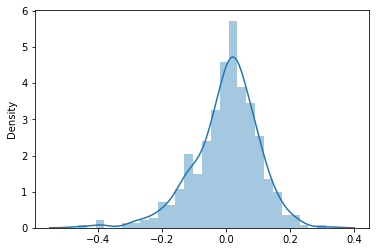

In [35]:
sns.distplot(res)

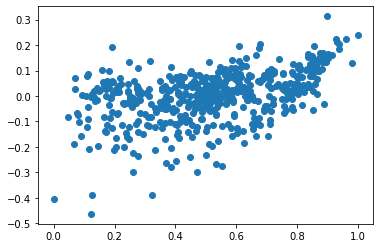

In [36]:
plt.scatter(y_train,res)

## EVALUATION ON TEST SET

In [37]:
X_test = df_test[X.columns]
y_test = df_test.cnt
X_test_sm = sm.add_constant(X_test)

In [38]:
y_test_pred = lr_model.predict(X_test_sm)

C:\Users\vssashar\AppData\Local\Temp\ipykernel_7588\1978107241.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res);


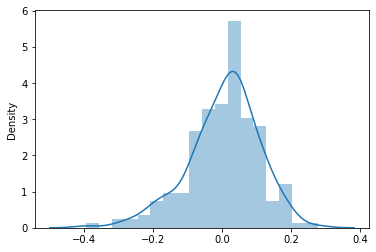

In [39]:
res = y_test-y_test_pred
sns.distplot(res);


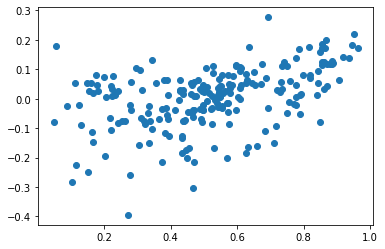

In [40]:
plt.scatter(y_test,res)

In [41]:
print("R-squared for training = ",r2_score(y_train,y_train_pred))
print("R-squared for testing = ",r2_score(y_test,y_test_pred))

R-squared for training =  0.7949565194804429
R-squared for testing =  0.7775633717518898


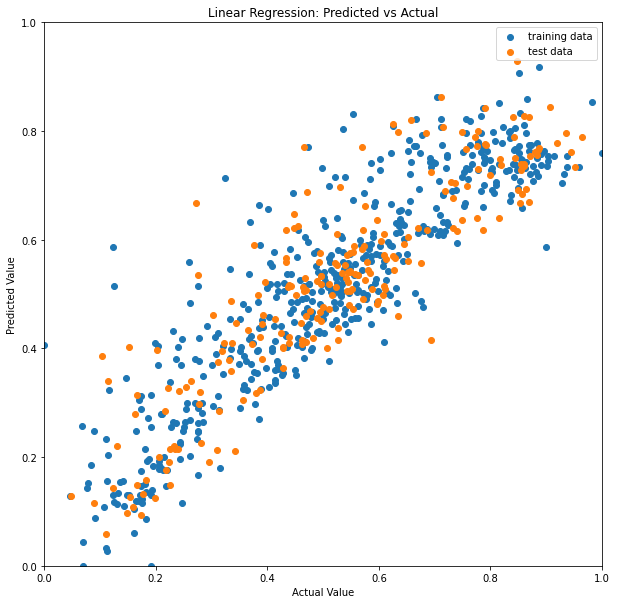

In [42]:
plt.figure(figsize=(10,10))
plt.scatter(y_train,y_train_pred,label = 'training data')
plt.scatter(y_test,y_test_pred,label = 'test data')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Linear Regression: Predicted vs Actual')
plt.legend()

## Our residues are in accordance with the following properties:
1. Homoscedasticity
2. Normality
3. Independence

Which are our assumptions for linear regression.

Also, both the $R^2$ values are reasonably high and hence our model can be accepted


Thus, our model can be written as:

$cnt_{normalized} = 0.0326+0.2320\times yr -0.0880\times holiday  + 0.0865\times season_2 + 0.1392\times season_4 + 0.0437\times mnth_8 +  0.1076 \times mnth_9 -0.2664\times weathersit_3 + 0.5666 \times temp_{normalized} $

## MODEL AFTER REMOVING NORMALIZATION
Let's look at the min_max scaler params and undo them on the model

In [43]:
list(zip(scaler.get_feature_names_out(),scaler.data_min_,scaler.data_max_,scaler.data_range_))

[('temp', 2.4243464, 35.328347, 32.9040006),
 ('atemp', 3.95348, 42.0448, 38.09132),
 ('hum', 0.0, 97.0417, 97.0417),
 ('cnt', 22.0, 8714.0, 8692.0)]

Thus, we have:

$cnt_{normalized} = 0.0326+0.2320\times yr -0.0880\times holiday  + 0.0865\times season_2 + 0.1392\times season_4 + 0.0437\times mnth_8 +  0.1076 \times mnth_9 -0.2664\times weathersit_3 + 0.5666 \times temp_{normalized} $

$\Rightarrow \frac{cnt-22}{8692} =  0.0326+0.2320\times yr -0.0880\times holiday  + 0.0865\times season_2 + 0.1392\times season_4 + 0.0437\times mnth_8 +  0.1076 \times mnth_9 -0.2664\times weathersit_3 + 0.5666 \times \frac{temp-2.4243464}{32.9040006}$

$\Rightarrow cnt = 22+8691\times(0.0326+0.2320\times yr -0.0880\times holiday  + 0.0865\times season_2 + 0.1392\times season_4 + 0.0437\times mnth_8 +  0.1076 \times mnth_9 -0.2664\times weathersit_3 + 0.5666 \times \frac{temp-2.4243464}{32.9040006})$

$\Rightarrow cnt = 149.66\times temp +2016.31\times yr -764.81\times holiday  + 751.77\times season_2 + 1209.79\times season_4 + 379.80\times mnth_8 +  935.15 \times mnth_9 -2315.28\times weathersit_3   -57.494$ 

Thus our final model can be approximately written as
# $cnt = 150\times temp +2016\times yr -765\times holiday  + 752\times season_2 + 1210\times season_4 + 380\times mnth_8 +  935 \times mnth_9 -2315\times weathersit_3   -57.5$ 

Text(0.5, 1.0, 'Linear Regression: Predicted vs Actual| Unnormalized')

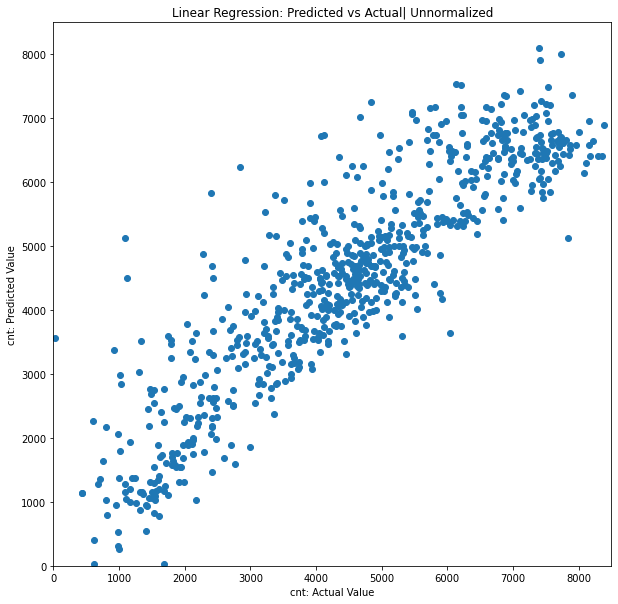

In [44]:
plt.figure(figsize=(10,10))
cnt_actual = df.cnt
cnt_pred = 150*df.temp+2016*df.yr-765*df.holiday+752*df.season_2+1210*df.season_4+380*df.mnth_8+935*df.mnth_9-2315*df.weathersit_3-57.5
plt.scatter(cnt_actual,cnt_pred)
plt.xlim(0,8500)
plt.ylim(0,8500)
plt.xlabel('cnt: Actual Value')
plt.ylabel('cnt: Predicted Value')
plt.title('Linear Regression: Predicted vs Actual| Unnormalized')

In [45]:
print("R-squared for overall unnormalized data = ",r2_score(cnt_actual,cnt_pred))

R-squared for overall unnormalized data =  0.7899756864425841


## Observations from the model
We see that following factor affect our count:


| Factor      | Impact nature |
| ----------- | ----------- |
| temperature ($temp$)     | + ve      |
| year  ($yr$) |+ ve|
| holiday ($holiday$)  | - ve   |
| summer ($season_2$)  |   + ve      |
| winter ($season_4$)   | + ve       |
| August ($mnth_8$)   | + ve        |
| September ($mnth_9$)   | + ve        |
| Bad weather ($weathersit_3$)   | - ve        |


All the above impacts are understandable and explainable
1. A warm temperature is favourable for cycling
2. The company would have increased its reach by the year so 2019 in general would have more customers than 2018
3. For a set of customers, commuting is mainly for work so holidays would mean these people will not commute.
4. Summer and winter vacations will attract student commuters, either for work or fun.
5. Bad weather, obviously, will reduce a lot of bike usage

#### The interesting observation here would be the special positive impact in the months of August and September. 

#### Why do we see increase in these months?

American college year starts in August-September (Fall Semester) and hence, we would have a lot of new students coming to campuses for the first time, using these bike services for commute until they purchase their own bike. This could probably be the reason behind this August-September spike